In [70]:
import os
import re
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import warnings
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
warnings.filterwarnings('ignore')

https://www.kaggle.com/code/marco22daniel/traffic-light-classification

In [71]:
target_classes = ['go', 'stop', 'warning']
color_map = {'go':'green', 'stop':'red', 'warning':'yellow'}
rgb_color_map = {'go': (0, 255, 0), 'stop': (255, 0, 0), 'warning': (255, 255, 0)}

train_folder_list = ['dayTrain']

n_samples_per_class = 1000

In [72]:
def get_annotarion_dataframe(train_data_folders):
    data_base_path = './input/lisa-traffic-light-dataset/'
    annotation_list = list()
    for folder in [folder + '/' for folder in train_data_folders if os.listdir(data_base_path)]:
        annotation_path = ''
        if 'sample' not in folder:
            annotation_path = data_base_path + 'Annotations/Annotations/' + folder
        else:
            annotation_path = data_base_path + folder*2
        image_frame_path = data_base_path + folder*2
        
        df = pd.DataFrame()
        if 'Clip' in os.listdir(annotation_path)[0]:
            clip_list = os.listdir(annotation_path)
            for clip_folder in clip_list:
                df = pd.read_csv(annotation_path + clip_folder +  '/frameAnnotationsBOX.csv', sep=";")
                df['image_path'] = image_frame_path + clip_folder + '/frames/'
                annotation_list.append(df)
        else:
            df = pd.read_csv(annotation_path +  'frameAnnotationsBOX.csv', sep=";")
            df['image_path'] = image_frame_path + 'frames/'
            annotation_list.append(df)
        
    df = pd.concat(annotation_list)
    df = df.drop(['Origin file', 'Origin frame number', 'Origin track', 'Origin track frame number'], axis=1)
    df.columns = ['filename', 'target', 'x1', 'y1', 'x2', 'y2', 'image_path']
    df = df[df['target'].isin(target_classes)]
    df['filename'] = df['filename'].apply(lambda filename: re.findall("\/([\d\w-]*.jpg)", filename)[0])
    df = df.drop_duplicates().reset_index(drop=True)
    return df

In [73]:
train_annotation_df = get_annotarion_dataframe(train_folder_list)

target_classes = train_annotation_df['target'].unique()
target_classes.sort()

train_annotation_df

,filename,target,x1,y1,x2,y2,image_path
0,dayClip1--00000.jpg,go,698,333,710,358,./input/lisa-traffic-light-dataset/dayTrain/da...
1,dayClip1--00000.jpg,go,846,391,858,411,./input/lisa-traffic-light-dataset/dayTrain/da...
2,dayClip1--00001.jpg,go,698,337,710,357,./input/lisa-traffic-light-dataset/dayTrain/da...
3,dayClip1--00001.jpg,go,847,390,859,410,./input/lisa-traffic-light-dataset/dayTrain/da...
4,dayClip1--00002.jpg,go,698,331,710,356,./input/lisa-traffic-light-dataset/dayTrain/da...
...,...,...,...,...,...,...,...
29693,dayClip9--00906.jpg,go,1139,157,1187,232,./input/lisa-traffic-light-dataset/dayTrain/da...
29694,dayClip9--00907.jpg,go,1159,153,1204,233,./input/lisa-traffic-light-dataset/dayTrain/da...
29695,dayClip9--00908.jpg,go,1185,150,1224,230,./input/lisa-traffic-light-dataset/dayTrain/da...
29696,dayClip9--00909.jpg,go,1199,141,1256,226,./input/lisa-traffic-light-dataset/dayTrain/da...


stop       15113
go         13830
warning      755
Name: target, dtype: int64

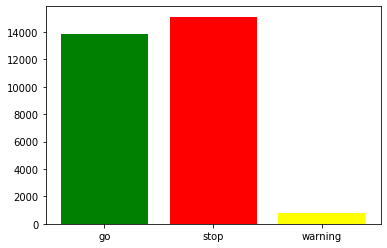

In [74]:
index, counts = np.unique(train_annotation_df['target'], return_counts=True)
colors = [color_map[target] for target in index]
plt.bar(index, counts, color=colors);
train_annotation_df['target'].value_counts()

In [75]:
train_annotation_df['target'].value_counts(normalize=True)

stop       0.508889
go         0.465688
warning    0.025423
Name: target, dtype: float64

In [76]:
def resample_dataset(annotation_df, n_samples):
    df_resample_list = list()
    for target in target_classes:
        df = annotation_df[annotation_df['target'] == target].copy()
        df_r = resample(df, n_samples=n_samples, random_state=42)
        df_resample_list.append(df_r)
    return pd.concat(df_resample_list).reset_index(drop=True)

train_annotation_df = resample_dataset(train_annotation_df, n_samples_per_class)

warning    1000
go         1000
stop       1000
Name: target, dtype: int64

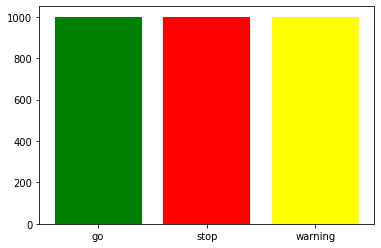

In [77]:
index, counts = np.unique(train_annotation_df['target'], return_counts=True)
colors = [color_map[target] for target in index]
plt.bar(index, counts, color=colors);
train_annotation_df['target'].value_counts()

In [78]:
def image_traffic_light_crop(df):

    img_values = dict()
    for index in tqdm(df.index, total=len(df)):
        row = df.loc[index]
        image_path = row["image_path"]
        filename = row["filename"]
        target = row["target"]
        x1, x2, y1, y2 = row["x1"], row["x2"], row["y1"], row["y2"]
        img = cv2.imread(image_path + filename)
        cropped_img = img[y1:y2, x1:x2]
        cropped_img = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
        img_values[index] = cropped_img
    return img_values



In [79]:
img_values = image_traffic_light_crop(train_annotation_df)

  0%|          | 0/3000 [00:00<?, ?it/s]

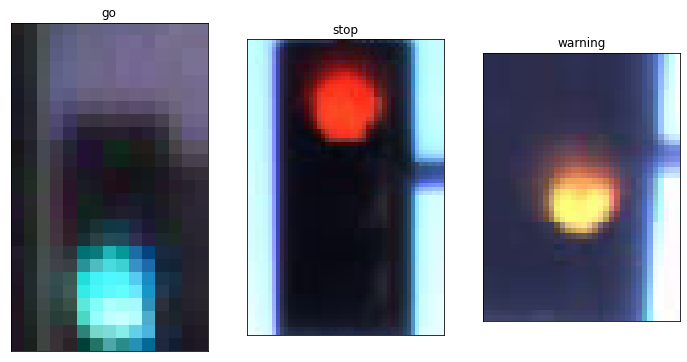

In [80]:
samples_imgs = dict()
for target in target_classes:
    index = train_annotation_df[train_annotation_df['target'] == target].index[0]
    img = img_values[index]
    samples_imgs[target] = img

_, axs = plt.subplots(1, len(target_classes), figsize=(12, 12))
axs = axs.flatten()
for target, ax in zip(samples_imgs, axs):
    ax.imshow(samples_imgs[target])
    ax.set_title(target)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.show()

In [81]:
def image_binarization(img_values):

    binary_img_values = dict()
    for index in tqdm(img_values, total=len(img_values)):
        img = img_values[index]
        img = cv2.resize(img, (30, 50))
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        _, binary_img = cv2.threshold(gray, 0, 255, 
                                      cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        binary_img[binary_img == 0] = 1
        binary_img[binary_img == 255] = 0
        binary_img_values[index] = binary_img
    return binary_img_values

binary_img_values = image_binarization(img_values)

  0%|          | 0/3000 [00:00<?, ?it/s]

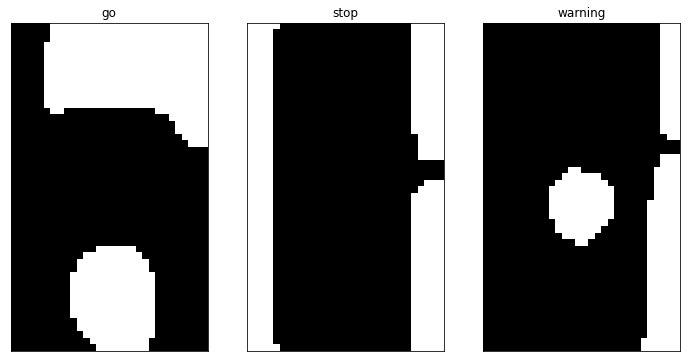

In [82]:
samples_imgs = dict()
for target in target_classes:
    index = train_annotation_df[train_annotation_df['target'] == target].index[0]
    img = binary_img_values[index]
    samples_imgs[target] = img

_, axs = plt.subplots(1, len(target_classes), figsize=(12, 12))
axs = axs.flatten()
for target, ax in zip(samples_imgs, axs):
    ax.imshow(samples_imgs[target], cmap='gray')
    ax.set_title(target)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.show()

In [83]:
def image_to_vector(binary_img_values, annotation_df):

    binary_img_vectors = dict()
    for index in tqdm(binary_img_values, total=len(binary_img_values)):
        img = binary_img_values[index]
        img_vector = np.c_[img.ravel()].transpose()[0]
        binary_img_vectors[index] = img_vector

    img_columns = ["p"+str(i) for i in range(1,1501)]
    df_img_values = pd.DataFrame(binary_img_vectors.values(), 
                                 index=binary_img_vectors.keys(), 
                                 columns=img_columns)
    return pd.merge(annotation_df, df_img_values, left_index=True, right_index=True)

df_img_values = image_to_vector(binary_img_values, train_annotation_df)
df_img_values.head()

  0%|          | 0/3000 [00:00<?, ?it/s]

,filename,target,x1,y1,x2,y2,image_path,p1,p2,p3,...,p1491,p1492,p1493,p1494,p1495,p1496,p1497,p1498,p1499,p1500
0,dayClip5--00296.jpg,go,675,359,690,384,./input/lisa-traffic-light-dataset/dayTrain/da...,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,dayClip1--01560.jpg,go,660,322,672,342,./input/lisa-traffic-light-dataset/dayTrain/da...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,dayClip2--00691.jpg,go,842,129,884,209,./input/lisa-traffic-light-dataset/dayTrain/da...,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,dayClip8--01037.jpg,go,1187,268,1238,318,./input/lisa-traffic-light-dataset/dayTrain/da...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,dayClip2--00317.jpg,go,1248,337,1275,382,./input/lisa-traffic-light-dataset/dayTrain/da...,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [84]:
X = df_img_values.drop(['filename', 'target', 'x1', 'y1', 'x2', 'y2', 'image_path'], axis=1)
y = df_img_values["target"]

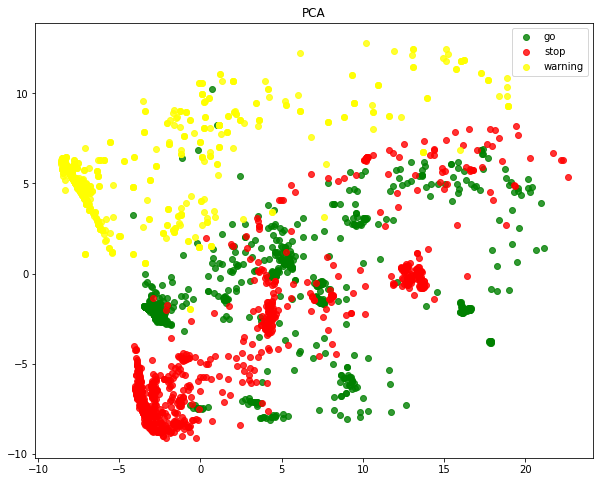

In [85]:
pca = PCA(n_components=2)
X_r = pca.fit_transform(X)
y_r = pd.Series(y.values.ravel())

plt.figure(figsize=(10,8))
for target in target_classes:
    plt.scatter(X_r[y_r == target, 0], 
                X_r[y_r == target, 1], 
                color=color_map[target], alpha=.8, label=target)
plt.legend(loc="best")
plt.title('PCA')
plt.show()

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [87]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train.values.ravel());

y_pred = dt.predict(X_test)
print(accuracy_score( y_test,y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score( y_test,y_pred))

0.9866666666666667
              precision    recall  f1-score   support

          go       0.98      0.98      0.98       250
        stop       0.99      0.98      0.98       250
     warning       0.99      1.00      1.00       250

    accuracy                           0.99       750
   macro avg       0.99      0.99      0.99       750
weighted avg       0.99      0.99      0.99       750

0.9866666666666667


In [88]:
lr = LogisticRegression(max_iter=500)
lr.fit(X_train, y_train.values.ravel());

y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))
print(accuracy_score( y_test,y_pred))

              precision    recall  f1-score   support

          go       1.00      0.98      0.99       250
        stop       0.99      1.00      0.99       250
     warning       0.99      1.00      0.99       250

    accuracy                           0.99       750
   macro avg       0.99      0.99      0.99       750
weighted avg       0.99      0.99      0.99       750

0.992


In [89]:
svc = SVC()
svc.fit(X_train, y_train.values.ravel());

y_pred = svc.predict(X_test)
print(classification_report(y_test, y_pred))
print(accuracy_score( y_test,y_pred))

              precision    recall  f1-score   support

          go       0.99      0.99      0.99       250
        stop       1.00      0.98      0.99       250
     warning       0.99      1.00      0.99       250

    accuracy                           0.99       750
   macro avg       0.99      0.99      0.99       750
weighted avg       0.99      0.99      0.99       750

0.9906666666666667


In [90]:
knn = KNeighborsClassifier()
knn.fit(X_train,  y_train.values.ravel())
y_pred= knn.predict(X_test)
print(accuracy_score( y_test,y_pred))
print(classification_report(y_test,y_pred))

0.984
              precision    recall  f1-score   support

          go       0.98      0.99      0.98       250
        stop       1.00      0.96      0.98       250
     warning       0.98      1.00      0.99       250

    accuracy                           0.98       750
   macro avg       0.98      0.98      0.98       750
weighted avg       0.98      0.98      0.98       750



In [91]:
test_folder_list = [
#     'dayTrain',
    'daySequence1',
    'daySequence2',
    'sample-dayClip6',
#     'nightTrain',
#     'nightSequence1',
#     'nightSequence2',
#     'sample-nightClip1',
]

n_samples_per_class = 100

test_annotation_df = get_annotarion_dataframe(test_folder_list)
test_annotation_df = resample_dataset(test_annotation_df, n_samples_per_class)
img_values = image_traffic_light_crop(test_annotation_df)
binary_img_values = image_binarization(img_values)
df_img_values = image_to_vector(binary_img_values, test_annotation_df)

X = df_img_values.drop(['filename', 'target', 'x1', 'y1', 'x2', 'y2', 'image_path'], axis=1)
y = df_img_values["target"]

y_pred = knn.predict(X)
print(classification_report(y, y_pred))
df_img_values['pred_target'] = y_pred

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

              precision    recall  f1-score   support

          go       0.90      0.86      0.88       100
        stop       0.82      0.89      0.85       100
     warning       0.89      0.85      0.87       100

    accuracy                           0.87       300
   macro avg       0.87      0.87      0.87       300
weighted avg       0.87      0.87      0.87       300



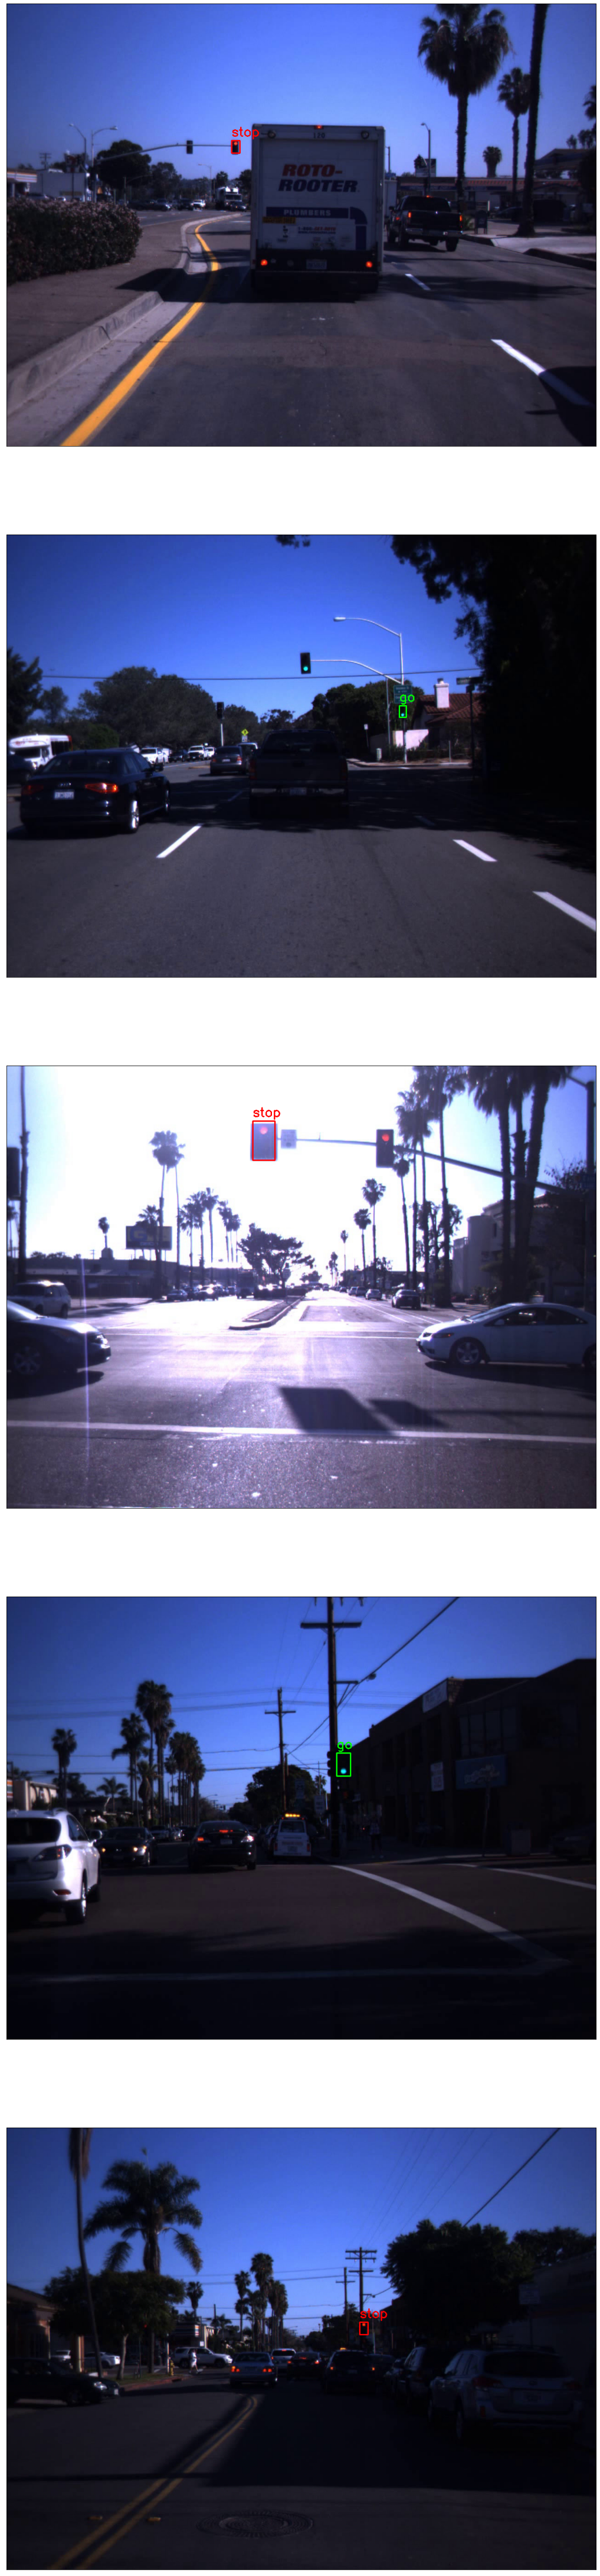

In [92]:
def show_image_with_label(df_sample, img_list):
    n_imgs = len(img_list)
    _, axs = plt.subplots(n_imgs, 1, figsize=(20*n_imgs, 16*n_imgs))
#     axs = axs.flatten()
    for filename, ax in zip(img_list, axs):
        df = df_sample[df_sample['filename'] == filename].copy()
        image_path = df['image_path'].values[0]
        img = cv2.imread(image_path + filename)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        for _, row in df.iterrows():
            target = row['pred_target']
            x1, x2, y1, y2 = row['x1'], row['x2'], row['y1'], row['y2']
            start_point = (x1, y1)
            end_point = (x2, y2)
            color = rgb_color_map[target]
            thickness = 2
            img = cv2.rectangle(img, start_point, end_point, color, thickness)
            img = cv2.putText(img, target, (x1, y1-10), 
                              cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
        ax.imshow(img)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
    plt.show()
    
sample_img_list = df_img_values['filename'].sample(5).values
show_image_with_label(df_img_values, sample_img_list)